In [57]:
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")
from metrics import f_score, auc_roc
from models import LinearSVM
from visualizations import plot_roc, plot_losses

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
train = np.load("../data/dataset_prep/train.npz")
x_train = train["x_train"]
y_train = train["y_train"]

In [59]:
x_train.shape, y_train.shape
# shape is (N, D)

((328135, 622), (328135,))

In [60]:
from preprocessing import COL_REMOVE_MANUAL, impute_missing_values, remove_duplicate_columns

# copied and altered `normalize_and_bias_data` from preprocessing.py to make it suitable for neural networks
# alterations
# > no need for bias since neuralnet already does it
# > no need for squared features since neural net can learn non-linear relationships

variable_type = []
with open("../data/metadata/variable_type.txt", "r") as f:
    for line in f:
        line = line.strip().strip('"')  # remove whitespace and surrounding quotes
        # split by comma and convert to int
        if line == "":
            variable_type.append([])
        else:
            variable_type.append(line)

# def normalize_and_bias_data(x_train, x_test=None, squared_features=True, feature_names=None):
def normalise_data(x_train, x_test=None, feature_names=None):

    """Standardize data and add bias term.
    Args:
        x_train: np.ndarray of shape (N_train, D)
        x_test: np.ndarray of shape (N_test, D)
    Returns:
        x_train_std: np.ndarray of shape (N_train, D+1)
        x_test_std: np.ndarray of shape (N_test, D+1)
    """ 
    if feature_names is None: feature_names = np.arange(x_train.shape[1])
    one_hot_encoding = x_train.shape[1] > len(variable_type) # one-hot encoding was applied

    # missing data imputation
    x_train = impute_missing_values(x_train, x_train)
    if x_test is not None: x_test = impute_missing_values(x_train, x_test)
    
    # manual duplicates removal
    x_train = np.delete(x_train, COL_REMOVE_MANUAL, axis=1)
    remaining_var_types = np.delete(variable_type, COL_REMOVE_MANUAL)
    feature_names = np.delete(feature_names, COL_REMOVE_MANUAL)
    assert feature_names.shape[0] == x_train.shape[1], "Feature names and data shape mismatch after manual duplicate removal."

    # invariant feature removal
    stds_train = np.std(x_train, axis=0)
    remove = (stds_train < 1e-10)
    x_train = x_train[:, ~remove]
    remaining_var_types = np.delete(remaining_var_types, remove[:len(remaining_var_types)])
    feature_names = np.delete(feature_names, remove)
    assert feature_names.shape[0] == x_train.shape[1], "Feature names and data shape mismatch after invariant feature removal."

    # feature scaling by standardization
    mean = x_train.mean(axis=0)
    std = x_train.std(axis=0)
    assert not np.any(std == 0), "At least one feature has zero standard deviation."
    x_train = (x_train - mean) / std
    
    # # squaring continuous features
    # if squared_features:
    #     squared_feature_idx = np.array([i for i, var_type in enumerate(remaining_var_types) if var_type in ["ordinal", "continuous"]])
    #     x_train = np.column_stack([x_train, x_train[:, squared_feature_idx] ** 2])
    #     squared_feature_names = [f"{feature_names[i]}_squared" for i in squared_feature_idx]
    #     feature_names = np.concatenate([feature_names, squared_feature_names])
    # assert feature_names.shape[0] == x_train.shape[1], "Feature names and data shape mismatch after squaring features."
    
    if one_hot_encoding: 
        one_hot_encoded = [i for i, t in enumerate(remaining_var_types) if t == "nominal"]
        x_train = np.delete(x_train, one_hot_encoded, axis=1)
        feature_names = np.delete(feature_names, one_hot_encoded)
        assert feature_names.shape[0] == x_train.shape[1], "Feature names and data shape mismatch after removing one-hot encoded features."

    # # add bias term
    # x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
    # feature_names = np.concatenate([np.array(["bias"]), feature_names])

    if x_test is None:
        x_train, kept_idx = remove_duplicate_columns(x_train)
        return x_train, feature_names[kept_idx]

    x_test = np.delete(x_test, COL_REMOVE_MANUAL, axis=1)
    x_test = x_test[:, ~remove]
    x_test = (x_test - mean) / std
    # if squared_features:
    #     x_test = np.column_stack([x_test, x_test[:, squared_feature_idx] ** 2])
    if one_hot_encoding: x_test = np.delete(x_test, one_hot_encoded, axis=1)
    # x_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
    x_train, x_test, kept_idx = remove_duplicate_columns(x_train, x_test)
    return x_train, x_test, feature_names[kept_idx]

In [61]:
x_train_norm, _ = normalise_data(x_train)
N = x_train_norm.shape[0]
D = x_train_norm.shape[1]

In [62]:
train_test_ratio = 0.9
split_index = int(N * train_test_ratio)

permutation = np.random.permutation(N) # randomising data incase of skew

x_train_reshape = x_train_norm.transpose()[:, permutation]
y_train_reshape = y_train.reshape(1, -1)[:, permutation]

x_train_final = x_train_reshape[:, :split_index]
y_train_final = y_train_reshape[:, :split_index]

x_test_local = x_train_reshape[:, split_index:N]
y_test_local = y_train_reshape[:, split_index:N]

x_train_final.shape, y_train_final.shape, x_test_local.shape, y_test_local.shape

((554, 295321), (1, 295321), (554, 32814), (1, 32814))

In [63]:
# eww why does python not have inline funcs
def ReLU(Z):
    return np.maximum(0, Z)

In [64]:
# i don't import binary_cross_entropy_loss from models, since it is not suitable for neuralnet
def binary_cross_entropy_loss(Y, A):
    # Y: (1, N)
    # A: (1, N)
    m = Y.shape[1]
    epsilon = 1e-9
    cost = -(1/m) * np.sum( Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon) )
    return np.squeeze(cost)

In [65]:
from implementations import sigmoid

class NeuralNet:
    
    # Output size will be 1 given it is a binary classification
    def __init__(self, layer_dims, learning_rate=0.01):

        # In layer_dims, we have [input_size, hidden_sizes ..., output_size]
        
        self.layer_dims = layer_dims
        self.L = len(layer_dims)
        self.learning_rate = learning_rate

        # Every hidden layer and the output layer has: weight matrix + bias vector
        self.params = {}
        for i in range(1, self.L): # start from 1, since 0 is input layer
            # Each column in weights matrix represents weights for one neuron, and small randomisation is necessary to break symmetry
            self.params[f"W{i}"] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01 # shape (curr, prev)
            self.params[f"b{i}"] = np.zeros((layer_dims[i], 1)) # shape (curr, 1)
        
    # note, X assumes shape (D, N) to perform multiple at the same time, returns logits of shape (1, N)
    def forward_propagation(self, X):
        cache = [] # need to store the history of all activations for backprop

        A = X # since the first layer is already normalised
        Z = X # just tmp

        for i in range(1, self.L):
            A_prev = A
            Z = np.dot(self.params[f"W{i}"], A_prev) + self.params[f"b{i}"]
            cache.append((A_prev, self.params[f"W{i}"], Z))
            if (i != self.L - 1): A = ReLU(Z)

        return Z, cache
    
    def predict(self, X):
        # X: (D, N)
        # output: (1, N)

        Z, _ = self.forward_propagation(X)
        return (Z > 0).astype(int)

    def train(self, X, Y, epochs=100, batch_size=32):
        # X: (D, N)
        # Y: (1, N)
        N = X.shape[1]
    
        cost_sample_rate_in_epochs = 2
        costs = []
        test_costs = []

        for i in range(epochs): 
            # need to do some shuffling to stop memorisation and overfitting
            permutation = np.random.permutation(N)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]

            for j in range(int(np.ceil(N/batch_size))):
                start = j * batch_size
                end = min((j + 1) * batch_size, N)

                X_batch = X_shuffled[:, start:end]
                Y_batch = Y_shuffled[:, start:end]
                real_batch_size = end - start

                # 1. for each batch perform forward propagation (we don't need to find the cross entropy loss since it works with derivatives)
                Z, cache = self.forward_propagation(X_batch)
                A = sigmoid(Z) 
                # C = binary_cross_entropy_loss(Y_batch, A)

                dA_prev = None
                for l in range(self.L - 1, 0, -1):
                    # 2. backprop formulas condensed
                    A_prev, W, Z = cache[l-1]

                    is_last_layer = l == self.L - 1
                    dZ = A - Y_batch if is_last_layer else dA_prev * (Z > 0).astype(int) # this last term is the derivate (kind of) of ReLU
                    dW = (1 / real_batch_size) * np.dot(dZ, A_prev.T)
                    db = (1 / real_batch_size) * np.sum(dZ, axis=1, keepdims=True)
                    
                    dA_prev = np.dot(W.T, dZ)

                    # 3. Update weights and biases of the network
                    self.params[f"W{l}"] = self.params[f"W{l}"] - self.learning_rate * dW
                    self.params[f"b{l}"] = self.params[f"b{l}"] - self.learning_rate * db
                
            # Doing some printing and tracking off cost.
            if i % cost_sample_rate_in_epochs == 0 or i == epochs - 1:
                Z, _ = self.forward_propagation(X) 
                A = sigmoid(Z)
                cost = binary_cross_entropy_loss(Y, A)
                costs.append(cost)
                print(f"Epoch {i}, Cost: {cost}")

                Z, _ = self.forward_propagation(x_test_local)
                A = sigmoid(Z)
                test_cost = binary_cross_entropy_loss(y_test_local, A)
                test_costs.append(test_cost)
                print(f".          Test Cost: {test_cost}")

        return costs, test_costs, cost_sample_rate_in_epochs


In [ ]:
D = x_train_final.shape[0]

nn = NeuralNet([D, 10, 1])
costs, test_costs, cost_sample_rate_in_epochs = nn.train(x_train_final, y_train_final, epochs=50)

Epoch 0, Cost: 0.22654589760832838
.          Test Cost: 0.22697501984963456
Epoch 2, Cost: 0.21719613347273722
.          Test Cost: 0.22320466950529133
Epoch 4, Cost: 0.21370260352048973
.          Test Cost: 0.22382645273753676
Epoch 6, Cost: 0.21170177360820872
.          Test Cost: 0.22413893722568473
Epoch 8, Cost: 0.21014149000371052
.          Test Cost: 0.22427903910251096
Epoch 10, Cost: 0.20895560447471942
.          Test Cost: 0.22526742970495886
Epoch 12, Cost: 0.20801567514538818
.          Test Cost: 0.22560516322371035
Epoch 14, Cost: 0.20754221367318867
.          Test Cost: 0.22684932065227228
Epoch 16, Cost: 0.20673304788859592
.          Test Cost: 0.2271832958788751
Epoch 18, Cost: 0.20628748814269232
.          Test Cost: 0.22754378992514204
Epoch 20, Cost: 0.20584619785828526
.          Test Cost: 0.22786172454565848
Epoch 22, Cost: 0.20550942585952164
.          Test Cost: 0.22882972648066913
Epoch 24, Cost: 0.20486657385165993
.          Test Cost: 0.2289436026

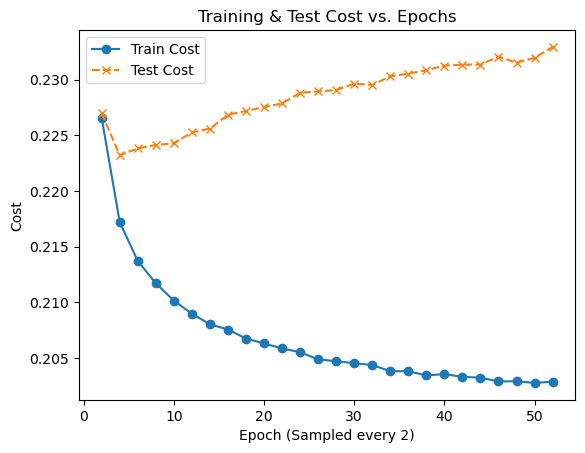

In [71]:
epochs = np.arange(1, len(costs) + 1) * cost_sample_rate_in_epochs
plt.plot(epochs, costs, marker='o', linestyle='-', label='Train Cost')
plt.plot(epochs, test_costs, marker='x', linestyle='--', label='Test Cost')

plt.title('Training & Test Cost vs. Epochs')
plt.xlabel(f'Epoch (Sampled every {cost_sample_rate_in_epochs})')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [68]:
y_pred = nn.predict(x_test_local)
print("F1 Score:", f_score(y_test_local, y_pred))
y_pred.shape, y_test_local.shape

F1 Score: 0.23406478578892373


((1, 32814), (1, 32814))

In [69]:
def hyperparemeter_tuning_neural_net():
    pass